# Introducción

Hemos llegado a Norg Bral.

# Librerías Importadas 

En primer lugar, reunimos las librerías adecuadas para atacar el problema que tenemos por delante. Esto es de gran importancia para ahorrar tiempo dedicado a trabajo manual y disponer de herramientas optimizadas.

In [1]:
# Librerías útiles para ciencia de datos y álgebra lineal
import numpy as np
import pandas as pd

# Librerías de procesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter

# Librerías para paths o sistema
from glob import glob

# Librerías para representaciones gráficas
import matplotlib.pyplot as plt

# Librerías de preferencias de display en notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) # Expande el tamaño de celdas al 80% del total
pd.set_option('display.max_rows', None) # Muestra todas las filas del dataframe

# Lectura de Datos

En la carpeta *datasets* encontramos los ficheros con la información necesaria para entrenamiento y testeo de nuestro modelo de clasificación.

##### Preexploración visual de documentos

La **estructura** que sigue es la siguiente:
    - nombre_clase/fichero

Las **clases** presentes son:
    - exploration
    - headhunters
    - intelligence
    - logistics
    - politics
    - transportation
    - weapons

Los nombres de los ficheros pueden contener números o caracteres especiales.

Ejemplos:
    - dataset/headhunters/.!31339!38291
    - dataset/intelligence/124146

En la siguiente celda contamos el número de ficheros de texto de los que disponemos para el problema.

In [2]:
# load filenames path
total_files = np.array(glob("dataset/*/*"))
class_files = np.array(glob("dataset/*"))

# print number of files in each dataset
print('There are {} total documents.'.format(len(total_files)))
print('There are {} different classes.'.format(len(class_files)))

There are 3859 total documents.
There are 7 different classes.


Los path de los ficheros tiene el aspecto siguiente:

In [3]:
print(total_files)

['dataset\\exploration\\59497' 'dataset\\exploration\\59846'
 'dataset\\exploration\\59848' ... 'dataset\\weapons\\55473'
 'dataset\\weapons\\55474' 'dataset\\weapons\\55475']


Definimos la función ```read_close``` que permite leer los mensajes uno a uno y hacer una concatenación de cada fichero en un único string

In [4]:
def read_close(path, mode='r'):
    '''
    With this function we read, group and put in a list the messages
    '''
    g = open(path, mode)
    out = g.readlines()
    out = ''.join(list(map(lambda x: x[:-1], out))) # Concatenate and drop \n from endlines
    g.close()
    return out

print(read_close('dataset\\exploration\\59497'))

In article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:>>> "Existence" is undefined unless it is synonymous with "observable" in>>> physics.>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of>> string theory?>>     I agree.  You can add "dark matter" and quarks and a lot of other>unobservable, purely theoretical constructs in physics to that list,>including the omni-present "black holes.">>     Will Bruce argue that their existence can be inferred from theory>alone?  Then what about my original criticism, when I said "Curvature>can only exist relative to something non-curved"?  Bruce replied:>"'Existence' is undefined unless it is synonymous with 'observable' in>physics.  We cannot observe more than the four dimensions we know about.">At the moment I don't see a way to defend that statement and the>existence of these unobs

Leemos los documentos y los guardamos en la variable ```docs```. Para obtener los labels usamos una expresión regular que permite sacarlos de los paths y los guardamos en la variable ```labels```.

In [5]:
def match_g(pattern, x, i):
    return re.match(pattern, x).group(i)

pat = r'.*\\(.*)\\(.*)$'
total = [(read_close(x,'r'), match_g(pat, x, 1)) for x in total_files]

docs = [x[0] for x in total]
labels = [x[1] for x in total]

assert((len(docs) == len(labels))&(len(docs) == len(total_files))) # Test to ensure that we have all the info labeled

In [6]:
def pretty_print_doc_and_label(i):
    '''
    Function to print label and doc
    '''
    print(labels[i] + "\t:\t" + docs[i][:80] + "...")

In [7]:
pretty_print_doc_and_label(500)
pretty_print_doc_and_label(1000)
pretty_print_doc_and_label(1500)
pretty_print_doc_and_label(2000)
pretty_print_doc_and_label(2500)
pretty_print_doc_and_label(3000)
pretty_print_doc_and_label(3500)

exploration	:	      Ethnocentric USian that I am, I've assumed that we and thexUSSR were the o...
headhunters	:	 Our shop uses a package called CADCore - very good - to scan andsubsequently ve...
intelligence	:	> Any thoughts on who is going to count all of the gorgeous bodies at > the MOW?...
logistics	:	 <C5prCA.590@news.cso.uiuc.edu>In article <C5prCA.590@news.cso.uiuc.edu>, cobb@a...
politics	:	In <C5HpG6.4LM@andy.bgsu.edu> klopfens@andy.bgsu.edu (Bruce Klopfenstein) writes...
transportation	:	In article <9833@dirac.physics.purdue.edu> lovall@bohr.physics.purdue.edu (Danie...
weapons	:	In article <1993Apr15.201756.29141@CSD-NewsHost.Stanford.EDU> andy@SAIL.Stanford...


# Análisis del Target

Cuando se va a abordar un problema de clasificación, es de suma importancia saber cómo se distribuyen las clases en el mismo.

Decimos que las clases están **balanceadas** cuando la frecuencia de aparición de todas ellas están en equilibrio.

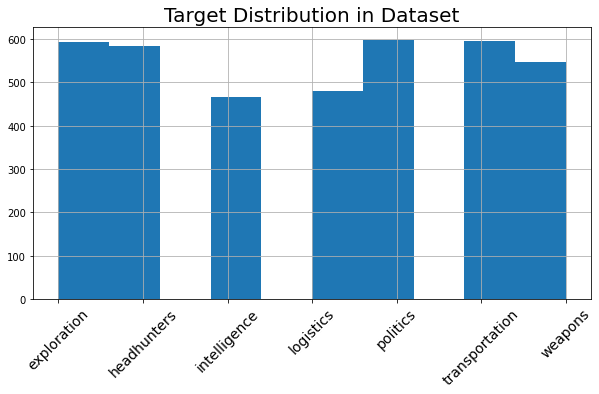

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(labels)
plt.xticks(rotation=45, fontsize=14)
plt.grid(True)
plt.title('Target Distribution in Dataset', fontsize=20)
plt.show()

En este caso, parece que sí están balanceadas. En caso de no haberlo estado, habríamos tenido que recurrir a técnicas como el upsampling, undersampling o el SMOTE.

    - Undersampling: Muestreo sin reemplazamiento que elimina filas de las clases con mayor presencia. Puede llevar a pérdidas de información y sesgo en el modelo.
    - Upsampling: Muestreo con reemplazamiento que añade filas repetidas para las clases con menor presencia hasta que sean equiparables a las demás. Puede llevar a overfitting debido a que las filas sampleadas adquieren mayor importancia.
    - SMOTE: Es similar al upsampling pero en este caso se perturban aleatoriamente las filas muestreadas para disminuir el efecto de overfitting causado por el upsampling. En este caso el problema es la introducción de ruido aleatorio en el modelo.

**NOTA**: El balance en nuestro problema no es completo porque las clases *intelligence* y *logistics* aparecen con menor frecuencia. No obstante, podemos suponer que la diferencia (~20%) puede ser despreciada en primera aproximación. No obstante, si se dispusiera del tiempo necesario se podrían probar las técnicas mencionadas previamente. 

# Definición de una Lógica 

Para trabajar con modelos de lenguaje, debido al gran esfuerzo computacional que conllevan, es importante facilitarle la comprensión de los mismos a la máquina. Para ello, es recomendable codificar la información e intentar eliminar todo aquello que pueda introducir ruido en el modelo. Para ello, es importante definir una serie de pasos de preparación y codificación que denominamos **lógica**.

Pasos fundamentales de una lógica de NLP:
    - Limpieza de texto: stop words, tokenización, ...
    - Definición de un vocabulario o conjunto de palabras que se usarán para codificar.
    - Elección de un método de codificación: frequence encoding, tfidf, ...

## Limpieza de texto

A priori, queremos que nuestro modelo aprenda principalmente de las palabras y no de los símbolos contenidos en cada texto. Aunque los símbolos nos pueden permitir hacer distinciones en algunos casos, pensamos que un modelo robusto no debería funcionar así de cara a su posible generalización incluso aunque se pierda precisión.

En NLP, las palabras inútiles o que debemos ignorar se denominan **stop words**. Esto incluiría preposiciones, determinantes o conjunciones entre otras categorías morfológicas.

Por otra parte, los símbolos extraños y de puntuación tampoco cabe esperar que aporten mucho al modelo, por lo que también nos interesaría eliminarlo. 

No queremos que estas palabras ocupen espacio en nuestra base de datos, o que ocupen un valioso tiempo de procesamiento. Para ello, podemos eliminarlas fácilmente, almacenando una lista de palabras que se consideran stop words. NLTK (Natural Language Toolkit) en python tiene una lista de stop words almacenadas en 16 idiomas diferentes.

### Stop Words

In [9]:
# nltk.download('stopwords')
print('STOP WORDS IN ENGLISH\n')
sw_en = stopwords.words('english')
print(sw_en)

STOP WORDS IN ENGLISH

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 

### Eliminar símbolos, números y convertir en minúsculas

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
print('Tokenize text dropping all punctuation symbols\n')
print(tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!'))

Tokenize text dropping all punctuation symbols

['Eighty', 'seven', 'miles', 'to', 'go', 'yet', 'Onward']


Aplicamos estas técnicas a nuestros documentos

In [11]:
docs_tk = [x.lower() for x in docs]
docs_tk = [tokenizer.tokenize(x) for x in docs_tk] # Tokenize
docs_tk = list(map(lambda x: [y for y in x if (y not in sw_en)&(re.findall(r'([0-9]+)|(_+)', y) == [])], docs_tk)) # We remove numbers too

In [12]:
print(docs_tk[0])

['article', 'well', 'sf', 'ca', 'us', 'metares', 'well', 'sf', 'ca', 'us', 'tom', 'van', 'flandern', 'writes', 'kelvin', 'seas', 'virginia', 'edu', 'cameron', 'randale', 'bass', 'writes', 'bruce', 'scott', 'launchpad', 'unc', 'edu', 'bruce', 'scott', 'writes', 'existence', 'undefined', 'unless', 'synonymous', 'observable', 'physics', 'crb', 'dong', 'dong', 'dong', 'hear', 'death', 'knell', 'string', 'theory', 'agree', 'add', 'dark', 'matter', 'quarks', 'lot', 'unobservable', 'purely', 'theoretical', 'constructs', 'physics', 'list', 'including', 'omni', 'present', 'black', 'holes', 'bruce', 'argue', 'existence', 'inferred', 'theory', 'alone', 'original', 'criticism', 'said', 'curvature', 'exist', 'relative', 'something', 'non', 'curved', 'bruce', 'replied', 'existence', 'undefined', 'unless', 'synonymous', 'observable', 'physics', 'cannot', 'observe', 'four', 'dimensions', 'know', 'moment', 'see', 'way', 'defend', 'statement', 'existence', 'unobservable', 'phenomena', 'simultaneously', 

### Train - Valid - Test split

Antes de construir un vocabulario, es necesario separar el conjunto de entrenamiento del de validación y del que se usará para testear. En esta ocasión vamos a tomar 80% train, 10% validación y 10% test intentando mantener las distribuciones de los targets.

In [13]:
def encode_label(labels, d_encoder=None):
    if d_encoder is None:
        d_encoder={}
        for i, label in enumerate(list(set(labels))):
            d_encoder[label] = i
    return [d_encoder[x] for x in labels], d_encoder

In [14]:
def train_test_split(docs_lab, per_train=.8, random_state=0):
    '''
    Function to split in 2 slices.
    Input:
        - docs_lab: List of [(doc1, label1, path1), ...]
        - per_train: Percentage of train size (per class)
        - random_state: seed for shuffling
    Output:
        - X_train, y_train
        - X_test, y_test
        - d_ind: Dictionary with the indices
    '''

    np.random.seed(random_state)
    np.random.shuffle(docs_lab) # It's important to shuffle and try to get same distribution in targets
    
    labels = [x[1] for x in docs_lab]
    
    # For each category we take its docs
    d_cat = {}
    for lab in set(labels):
        ls_docs_lab = []

        for x in docs_lab:
            if (x[1] == lab):
                ls_docs_lab.append(x)
        d_cat[lab] = ls_docs_lab

    # Keep the per_train % for each class
    docs_tk_train = []
    for x in set(labels):
        docs_tk_train += (d_cat[x][:int(per_train*len(d_cat[x]))])
    
    docs_tk_test = [x for x in docs_lab if x not in docs_tk_train]
    
    np.random.shuffle(docs_tk_train)
    np.random.shuffle(docs_tk_test)
    
    d_ind = {}
    
    X_train = [x[0] for x in docs_tk_train]
    y_train = [x[1] for x in docs_tk_train]
    d_ind['train'] = [x[2] for x in docs_tk_train]
    
    X_test = [x[0] for x in docs_lab if x not in docs_tk_train]
    y_test = [x[1] for x in docs_lab if x not in docs_tk_train]
    d_ind['test'] = [x[2] for x in docs_lab if x not in docs_tk_train]
    
    return X_train, y_train, X_test, y_test, d_ind

In [15]:
docs_tk_tot = list(zip(docs_tk, labels, total_files))
X_train, y_train, X_test, y_test, d_ind = train_test_split(docs_tk_tot)

y_train, d_train = encode_label(y_train)
y_test, _ = encode_label(y_test, d_train)

In [16]:
print('X_train: {}\ny_train: {}\nX_test: {}\ny_test: {}'.format(len(X_train), len(y_train), len(X_test), len(y_test)))

X_train: 3085
y_train: 3085
X_test: 774
y_test: 774


In [17]:
print('TRAIN\n')
print(X_train[20])
print(y_train[20])

print('TEST\n')
print(X_test[7])
print(y_test[7])

TRAIN

['article', 'transfer', 'stratus', 'com', 'cdt', 'sw', 'stratus', 'com', 'c', 'tavares', 'writes', 'article', 'ousrvr', 'oulu', 'fi', 'dfo', 'vttoulu', 'tko', 'vtt', 'fi', 'foxvog', 'douglas', 'writes', 'article', 'transfer', 'stratus', 'com', 'cdt', 'sw', 'stratus', 'com', 'c', 'tavares', 'writes', 'article', 'ulowell', 'ulowell', 'edu', 'jrutledg', 'cs', 'ulowell', 'edu', 'john', 'lawrence', 'rutledge', 'writes', 'massive', 'destructive', 'power', 'many', 'modern', 'weapons', 'makes', 'cost', 'accidental', 'crimial', 'usage', 'weapons', 'great', 'weapons', 'mass', 'destruction', 'need', 'control', 'government', 'individual', 'access', 'would', 'result', 'needless', 'deaths', 'millions', 'makes', 'right', 'people', 'keep', 'bear', 'many', 'modern', 'weapons', 'non', 'existant', 'thanks', 'stating', 'coming', 'needless', 'say', 'disagree', 'every', 'count', 'believe', 'individuals', 'right', 'weapons', 'mass', 'destruction', 'find', 'hard', 'believe', 'would', 'support', 'neighb

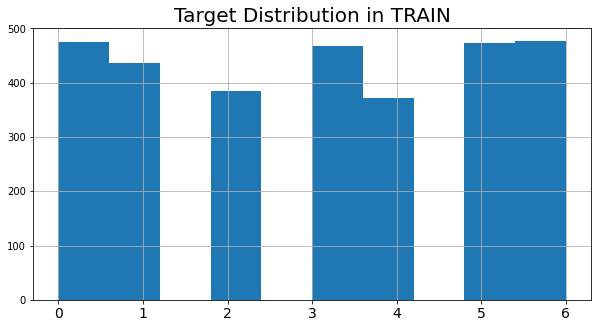

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(y_train)
plt.xticks(rotation=0, fontsize=14)
plt.grid(True)
plt.title('Target Distribution in TRAIN', fontsize=20)
plt.show()

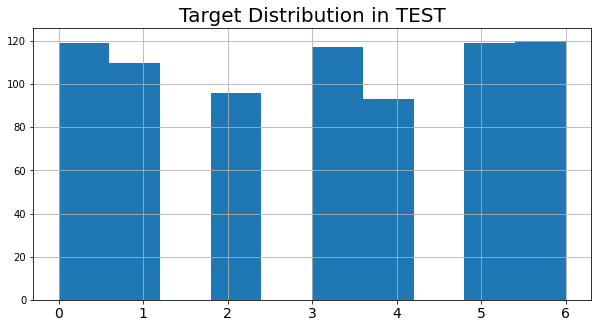

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(y_test)
plt.xticks(rotation=0, fontsize=14)
plt.grid(True)
plt.title('Target Distribution in TEST', fontsize=20)
plt.show()

### Build a Vocabulary From Train set

Un vocabulario es un conjunto de palabras únicas presentes en el conjunto de entrenamiento que usamos para codificar las palabras o tokens presentes en el mismo. No es necesario usar todas las que aparecen en el texto de entrenamiento. El tamaño del vocabulario es uno de los parámetros que podemos ajustar cuando se prepara el modelo, siempre teniendo en cuenta el trade-off entre rendimiento y accuracy que deseamos.

In [20]:
# La variable w_train almacena todas las palabras del train
w_train = []
for x in X_train:
    w_train += x

# El vocabulario usado en este caso será el total de las palabras que aparecen en el train
vocab = list(set(w_train))
print(len(vocab))

50865


In [21]:
print('Podemos comprobar cuáles son las palabras más frecuentes')
Counter(w_train).most_common(50)

Podemos comprobar cuáles son las palabras más frecuentes


[('edu', 3946),
 ('would', 2776),
 ('writes', 2696),
 ('article', 2496),
 ('one', 2352),
 ('com', 2215),
 ('people', 1889),
 ('like', 1640),
 ('think', 1627),
 ('know', 1385),
 ('get', 1312),
 ('time', 1177),
 ('also', 1171),
 ('well', 1146),
 ('good', 1103),
 ('could', 1040),
 ('c', 956),
 ('even', 947),
 ('see', 943),
 ('space', 935),
 ('make', 928),
 ('us', 918),
 ('new', 911),
 ('much', 906),
 ('year', 886),
 ('way', 867),
 ('right', 864),
 ('many', 855),
 ('say', 845),
 ('first', 838),
 ('use', 827),
 ('may', 824),
 ('two', 781),
 ('said', 780),
 ('q', 774),
 ('car', 740),
 ('go', 705),
 ('gun', 700),
 ('something', 692),
 ('going', 672),
 ('last', 667),
 ('e', 661),
 ('believe', 661),
 ('anyone', 660),
 ('god', 658),
 ('want', 650),
 ('better', 638),
 ('government', 634),
 ('really', 626),
 ('point', 614)]

In [22]:
# Diccionario con tabla lookup para las palabras del vocabulario
word2index = {}
for i, word in enumerate(vocab):
    word2index[word] = i

## Lógica: Frequence Encoding

It consists on counting the times that each vocabulary word appears in the corpus.

In [23]:
def CountVector(row):
    '''
    Counts the frequence for each word in each word
    '''
    layer_0 = np.zeros((1, len(vocab)))
    for x in row:
        if x in word2index.keys():
            layer_0[0][word2index[x]] += 1
    
    return layer_0


In [24]:
count_v_train = np.vstack([CountVector(x) for x in X_train])
# count_v_train = count_v_train / 
count_v_test = np.vstack([CountVector(x) for x in X_test])

In [25]:
np.sum(count_v_test[0])

113.0

In [26]:
np.sum(count_v_test[2])

492.0

**MÉTRICAS**:
- Escogemos la **Multiclass Log Loss**, una métrica ampliamente usada en problemas de clasificación multitarget. Sin entrar en mucho detalle, esta métrica nos da una idea de cómo de diferentes entre sí son las probabilidades asignadas a cada clase. Nos da una medida de la robustez de la solución propuesta.
- En segundo lugar, y puesto que los targets estan balanceados, empleamos la **accuracy** (o porcentaje de acierto).
- Podría usarse una variante de la curva ROC y el AUC para problemas multiclase llamada **macro-average ROC** obtenida promediando por las ROC individuales de cada clase. Se deja para futuras mejoras y desarrollos.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

def accuracy(actual, predicted):
    corr = np.zeros(actual.shape)
    for i, arr in enumerate(predicted):
        corr[i] = (np.argmax(arr) == actual[i])
#         print(np.argmax(arr), actual[i], corr[i])
    return np.sum(corr) / len(corr)

**ESCALADO**:
Puesto que se aplicará una Regresión logística y ésta usa métricas basadas en distancias, se considera necesario escalar. Se ha escogido a conveniencia el ```MinMaxScaler```

In [28]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
count_v_train = mm.fit_transform(count_v_train)
count_v_test = mm.transform(count_v_test)

### Regresión Logística

**MODELO 1 - Regresión Logística**: Modelo sencillo correspondiente a una red neuronal de una sola neurona. Es un modelo que permite alta explicabilidad y computacionalmente poco costoso.

In [29]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(count_v_train, y_train)
predictions = clf.predict_proba(count_v_test)

print("logloss: %0.3f " % multiclass_logloss(np.array(y_test), predictions))
print("Accuracy: %0.3f " % accuracy(np.array(y_test), predictions))

logloss: 0.568 
Accuracy: 0.889 


In [30]:
conf = np.zeros((predictions.shape[0], 3))
d_train_inv = {v: k for k, v in d_train.items()}
for i, arr in enumerate(predictions):
    conf[i] = np.array([np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i]])
#     print(np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i])
df_err = pd.DataFrame(conf[conf[:, 2] == 0], columns=['PREDICTED', 'REAL', 'COINCIDENT_BOOL']).astype('int')
df_err['PREDICTED'] = df_err['PREDICTED'].map(d_train_inv)
df_err['REAL'] = df_err['REAL'].map(d_train_inv)
df_err

,PREDICTED,REAL,COINCIDENT_BOOL
0,headhunters,weapons,0
1,exploration,weapons,0
2,headhunters,exploration,0
3,politics,weapons,0
4,transportation,weapons,0
5,headhunters,intelligence,0
6,headhunters,weapons,0
7,headhunters,transportation,0
8,headhunters,exploration,0
9,politics,intelligence,0


In [31]:
print('ERRORES MÁS COMUNES (PREDICHO_REAL)')
df_err.apply(lambda x: '_'.join([x['PREDICTED'], x['REAL']]),axis=1).value_counts()

ERRORES MÁS COMUNES (PREDICHO_REAL)


headhunters_exploration        14
headhunters_transportation     12
headhunters_weapons            11
headhunters_politics            7
transportation_intelligence     4
weapons_intelligence            4
headhunters_intelligence        4
exploration_headhunters         3
headhunters_logistics           3
politics_weapons                3
politics_exploration            2
logistics_intelligence          2
transportation_weapons          2
transportation_logistics        2
politics_logistics              2
politics_intelligence           2
exploration_intelligence        1
logistics_headhunters           1
politics_headhunters            1
exploration_weapons             1
intelligence_weapons            1
intelligence_exploration        1
transportation_politics         1
politics_transportation         1
exploration_transportation      1
dtype: int64

**RESULTADOS**
Parece que existe un problema a la hora de clasificar los documentos de headhunter. Predecimos cmo headhunter cosas que no lo son.

### Naive Bayes

**MODELO 2 - Naive Bayes Classifier**: Bajo la aunción de independencia entre los predictores, este algoritmo asume, empleando la fórmula de probabilidad a posteriori de Bayes, que existe proporcionalidad entre las probabilidades condicionadas. Su uso es muy frecuente en problemas de clasificación de Spam. Además, no dispone de una gran cantidad de hiperparámetros para tunear.

In [32]:
from sklearn.naive_bayes import MultinomialNB

# Fitting a simple Naive Bayes on Counts
clf_nb = MultinomialNB()
clf_nb.fit(count_v_train, y_train)
predictions_nb = clf_nb.predict_proba(count_v_test)

print ("logloss: %0.3f " % multiclass_logloss(np.array(y_test), predictions_nb))
print ("Accuracy: %0.3f " % accuracy(np.array(y_test), predictions_nb))

logloss: 0.301 
Accuracy: 0.928 


**DÓNDE FALLAMOS**

In [33]:
conf = np.zeros((predictions_nb.shape[0], 3))
d_train_inv = {v: k for k, v in d_train.items()}
for i, arr in enumerate(predictions_nb):
    conf[i] = np.array([np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i]])
#     print(np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i])
df_err_nb = pd.DataFrame(conf[conf[:, 2] == 0], columns=['PREDICTED', 'REAL', 'COINCIDENT_BOOL']).astype('int')
df_err_nb['PREDICTED'] = df_err_nb['PREDICTED'].map(d_train_inv)
df_err_nb['REAL'] = df_err_nb['REAL'].map(d_train_inv)
df_err_nb

,PREDICTED,REAL,COINCIDENT_BOOL
0,transportation,weapons,0
1,weapons,politics,0
2,logistics,exploration,0
3,headhunters,intelligence,0
4,headhunters,transportation,0
5,weapons,headhunters,0
6,exploration,headhunters,0
7,transportation,headhunters,0
8,weapons,intelligence,0
9,headhunters,politics,0


In [34]:
print('ERRORES MÁS COMUNES (PREDICHO_REAL)')
df_err_nb.apply(lambda x: '_'.join([x['PREDICTED'], x['REAL']]),axis=1).value_counts()

ERRORES MÁS COMUNES (PREDICHO_REAL)


exploration_headhunters        5
weapons_intelligence           5
intelligence_logistics         4
transportation_intelligence    3
headhunters_exploration        3
politics_headhunters           3
weapons_transportation         3
weapons_politics               3
transportation_headhunters     3
intelligence_exploration       2
intelligence_transportation    2
transportation_politics        2
exploration_intelligence       1
headhunters_intelligence       1
politics_exploration           1
logistics_weapons              1
politics_weapons               1
intelligence_weapons           1
weapons_exploration            1
headhunters_transportation     1
headhunters_politics           1
intelligence_headhunters       1
exploration_transportation     1
logistics_politics             1
weapons_logistics              1
transportation_weapons         1
weapons_headhunters            1
exploration_logistics          1
logistics_exploration          1
logistics_intelligence         1
dtype: int

**RESULTADOS**: Parece que el uso del clasificador Naïva Bayes está solucionando el problema que encontramos antes con la categoría headhunters

## Lógica: TF-IDF

This time we use a classical alternative approach to Frequence Encoding: Term Frequency - Inverse Document Frequency (TF-IDF).


**TF**: El número de veces que una palabra aparece en un documento dividido por el número total de palabras del documento. Cada documento tiene su propia frecuencia de términos.

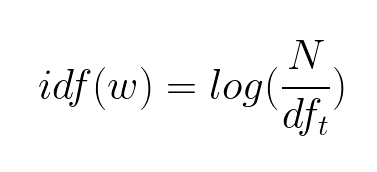

**IDF**: El logaritmo del número de documentos dividido por el número de documentos que contienen la palabra w. La frecuencia de datos invertida determina el peso de las palabras raras en todos los documentos del corpus.

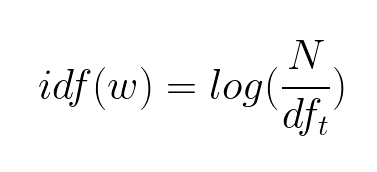

In [35]:
# Debido al coste computacional de este método, introducimos una variable de frecuencia mínima para reducir el tamaño del vocabulario
MIN_FREQ = 20
vocab_red = [x for x, v in Counter(w_train).items() if v>MIN_FREQ]

word2index_red = {}
for i, word in enumerate(vocab_red):
    word2index_red[word] = i

In [36]:
# print(word2index)
def computeIDF(documents, vocabulary):
    '''
    Función para calcular el IDF de cada palabra del vocabulario
    
    In
    '''
    N = len(documents) # Número de documentos
    
    d_words = Counter() #Inicialización de un contador
    for word in vocabulary:
        for document in documents:
            if word in document:
                d_words[word] += 1
        d_words[word] = np.log((N + 1) / d_words[word]) + 1 # Los +1 se introducen por motivos de estabilidad
    return d_words

def TFIDF(row, d_words):
    layer_0 = np.zeros((1, len(d_words.keys())))
    for x in row:
        if x in word2index_red.keys():
            layer_0[0][word2index_red[x]] += 1 / d_words[x] 
    return layer_0

In [37]:
d_idf = computeIDF(X_train, vocab_red)

In [38]:
X_train_tfidf = np.vstack([TFIDF(x, d_idf) for x in X_train])
X_test_tfidf = np.vstack([TFIDF(x, d_idf) for x in X_test])

In [39]:
mm_tfidf = MinMaxScaler()
X_train_tfidf = mm_tfidf.fit_transform(X_train_tfidf)
X_test_tfidf = mm_tfidf.transform(X_test_tfidf)

### Regresión Logística

In [40]:
# Fitting a simple Logistic Regression on TFIDF
clf_idf = LogisticRegression(C=1.0, max_iter=10000000)
clf_idf.fit(X_train_tfidf, y_train)
predictions_tfidf = clf_idf.predict_proba(X_test_tfidf)

print ("logloss: %0.3f " % multiclass_logloss(np.array(y_test), predictions_tfidf))
print ("Accuracy: %0.3f " % accuracy(np.array(y_test), predictions_tfidf))

logloss: 0.677 
Accuracy: 0.850 


In [41]:
conf_tfidf = np.zeros((predictions_tfidf.shape[0], 3))
d_train_inv = {v: k for k, v in d_train.items()}
for i, arr in enumerate(predictions_tfidf):
    conf_tfidf[i] = np.array([np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i]])
#     print(np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i])
df_err_tfidf = pd.DataFrame(conf_tfidf[conf_tfidf[:, 2] == 0], columns=['PREDICTED', 'REAL', 'COINCIDENT_BOOL']).astype('int')
df_err_tfidf['PREDICTED'] = df_err_tfidf['PREDICTED'].map(d_train_inv)
df_err_tfidf['REAL'] = df_err_tfidf['REAL'].map(d_train_inv)
df_err_tfidf

,PREDICTED,REAL,COINCIDENT_BOOL
0,transportation,weapons,0
1,transportation,exploration,0
2,exploration,weapons,0
3,transportation,weapons,0
4,headhunters,exploration,0
5,politics,weapons,0
6,politics,exploration,0
7,headhunters,exploration,0
8,transportation,weapons,0
9,headhunters,intelligence,0


In [42]:
print('ERRORES MÁS COMUNES (PREDICHO_REAL)')
df_err_tfidf.apply(lambda x: '_'.join([x['PREDICTED'], x['REAL']]),axis=1).value_counts()

ERRORES MÁS COMUNES (PREDICHO_REAL)


headhunters_exploration        17
headhunters_transportation     15
headhunters_weapons             9
headhunters_politics            7
transportation_intelligence     6
transportation_weapons          5
weapons_intelligence            5
headhunters_intelligence        5
politics_exploration            5
transportation_logistics        4
transportation_headhunters      4
headhunters_logistics           3
exploration_weapons             3
politics_intelligence           3
exploration_headhunters         2
intelligence_logistics          2
intelligence_weapons            2
politics_weapons                2
politics_headhunters            2
weapons_exploration             2
transportation_exploration      2
weapons_logistics               2
exploration_politics            1
politics_logistics              1
exploration_intelligence        1
intelligence_headhunters        1
weapons_transportation          1
exploration_logistics           1
logistics_weapons               1
logistics_inte

### Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB

# Fitting a simple Naive Bayes on Counts
clf_nb_idf = MultinomialNB()
clf_nb_idf.fit(X_train_tfidf, y_train)
predictions_nb_tfidf = clf_nb_idf.predict_proba(X_test_tfidf)

print ("logloss: %0.3f " % multiclass_logloss(np.array(y_test), predictions_nb_tfidf))
print ("Accuracy: %0.3f " % accuracy(np.array(y_test), predictions_nb_tfidf))

logloss: 0.527 
Accuracy: 0.846 


In [44]:
conf_nb_tfidf = np.zeros((predictions_nb_tfidf.shape[0], 3))
d_train_inv = {v: k for k, v in d_train.items()}
for i, arr in enumerate(predictions_nb_tfidf):
    conf_nb_tfidf[i] = np.array([np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i]])
#     print(np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i])
df_err_nb_tfidf = pd.DataFrame(conf_nb_tfidf[conf_nb_tfidf[:, 2] == 0], columns=['PREDICTED', 'REAL', 'COINCIDENT_BOOL']).astype('int')
df_err_nb_tfidf['PREDICTED'] = df_err_nb_tfidf['PREDICTED'].map(d_train_inv)
df_err_nb_tfidf['REAL'] = df_err_nb_tfidf['REAL'].map(d_train_inv)
df_err_nb_tfidf

,PREDICTED,REAL,COINCIDENT_BOOL
0,transportation,exploration,0
1,transportation,weapons,0
2,logistics,weapons,0
3,transportation,politics,0
4,logistics,exploration,0
5,transportation,weapons,0
6,headhunters,exploration,0
7,exploration,weapons,0
8,politics,exploration,0
9,headhunters,exploration,0


In [45]:
print('ERRORES MÁS COMUNES (PREDICHO_REAL)')
df_err_nb_tfidf.apply(lambda x: '_'.join([x['PREDICTED'], x['REAL']]),axis=1).value_counts()

ERRORES MÁS COMUNES (PREDICHO_REAL)


headhunters_exploration        14
weapons_intelligence           10
politics_exploration            8
headhunters_weapons             8
transportation_headhunters      6
transportation_intelligence     6
politics_headhunters            6
headhunters_transportation      6
transportation_exploration      5
transportation_weapons          4
headhunters_politics            4
weapons_logistics               3
logistics_intelligence          3
logistics_transportation        3
politics_weapons                3
logistics_exploration           3
transportation_politics         2
exploration_transportation      2
headhunters_logistics           2
logistics_weapons               2
transportation_logistics        2
exploration_logistics           2
politics_intelligence           2
intelligence_logistics          2
politics_transportation         2
intelligence_politics           1
exploration_intelligence        1
intelligence_weapons            1
headhunters_intelligence        1
weapons_politi

## Word Embedding 

Con algo más de tiempo, mi intención habría sido usar **PyTorch** para usar un embedding obtenido usando redes neuronales e introducirlo en los mismos modelos. Lo principal de los embeddings es que permite tener más en cuenta las relaciones entre palabras y su similitud (e.g. similitud del coseno).

# SKlearn, Pipelines y Validación Cruzada

Una vez hechas manualmente las construcciones, es interesante recurrir a la amplia flexibilidad que la clase ```sklearn``` nos ofrece a la hora de probar distintos modelos.

Además, hasta el momento, todas las evaluaciones se han hecho con ```train``` y ```test``` fijados al inicio del informe. No obstante, es bien sabido que este no es el método que nos garantiza una mayor generalizabilidad puesto que es posible que la elección inicial favorezca al modelo en su entrenamiento. Es por ello que resulta de especial interés la **Validación Cruzada**.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

docs_pipe = list(zip(docs, labels, total_files))

X_train_pipe, y_train_pipe, X_test_pipe, y_test_pipe, d_ind_pipe = train_test_split(docs_pipe)

y_train_pipe, d_train_pipe = encode_label(y_train_pipe)
y_test_pipe, _ = encode_label(y_test_pipe, d_train_pipe)
    
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# multiclass = make_scorer(multiclass_logloss)

d_scores = {}
for name, clf_pl in [('NB', MultinomialNB()), ('LR', LogisticRegression(C=1.0))]: #, ('RF', RandomForestClassifier())
    pipe = pipeline.Pipeline(steps = [('tfv', tfv),
#                                       ('ToArr', preprocessing.FunctionTransformer(lambda x: x.toarray())), # To avoid problems due to sparsity from tfv
                                      ('MM', preprocessing.MaxAbsScaler()),
                                      (name, clf_pl)])


#     pipe.fit(X_train_pipe,y_train_pipe)
    scores = model_selection.cross_validate(pipe, X_train_pipe, np.array(y_train_pipe), scoring={'accuracy':'accuracy'}, return_estimator=True) # , 'MC_LogLoss':multiclass
    
    d_scores.update({'_'.join([k, name]): v for k, v in scores.items()})
    

In [51]:
df_res_cv = pd.DataFrame.from_dict(d_scores, orient='columns').mean()
df_res_cv

fit_time_NB         1.381047
score_time_NB       0.202607
test_accuracy_NB    0.946515
fit_time_LR         4.285163
score_time_LR       0.207474
test_accuracy_LR    0.941977
dtype: float64

De nuevo, obtenemos mejores resultados de rendimiento y precisión para el **Naive Bayes** en 5 folds. En esta ocasión se obtienen mejores resultados principalmente porque no sólo se tienen en cuenta los 1-gramas sino 1, 2 y 3 - gramas en tfidf.

In [53]:
from sklearn.metrics import accuracy_score

pipe = pipeline.Pipeline(steps = [('tfv', tfv),
#                                       ('ToArr', preprocessing.FunctionTransformer(lambda x: x.toarray())), # To avoid problems due to sparsity from tfv
                                      ('MM', preprocessing.MaxAbsScaler()),
                                      ('NB', MultinomialNB())])

pipe.fit(X_train_pipe,y_train_pipe)

Pipeline(steps=[('tfv',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=1, token_pattern='\\w{1,}',
                                 use_idf=1)),
                ('MM', MaxAbsScaler()), ('NB', MultinomialNB())])

In [54]:
predictions_nb_sk = pipe.predict_proba(X_test_pipe)
# accuracy_score(y_test_pipe, predictions_nb_sk)
print ("logloss: %0.3f " % multiclass_logloss(np.array(y_test_pipe), predictions_nb_sk))
print ("Accuracy: %0.3f " % accuracy(np.array(y_test_pipe), predictions_nb_sk))

logloss: 0.578 
Accuracy: 0.934 


In [55]:
conf = np.zeros((predictions_nb.shape[0], 3))
d_train_inv = {v: k for k, v in d_train.items()}
for i, arr in enumerate(predictions_nb_sk):
    conf[i] = np.array([np.argmax(arr), y_test[i], np.argmax(arr) == y_test_pipe[i]])
#     print(np.argmax(arr), y_test[i], np.argmax(arr) == y_test[i])
df_err_nb_sk = pd.DataFrame(conf[conf[:, 2] == 0], columns=['PREDICTED', 'REAL', 'COINCIDENT_BOOL']).astype('int')
df_err_nb_sk['PREDICTED'] = df_err_nb_sk['PREDICTED'].map(d_train_inv)
df_err_nb_sk['REAL'] = df_err_nb_sk['REAL'].map(d_train_inv)
df_err_nb_sk

,PREDICTED,REAL,COINCIDENT_BOOL
0,transportation,weapons,0
1,politics,exploration,0
2,exploration,weapons,0
3,intelligence,politics,0
4,headhunters,exploration,0
5,politics,exploration,0
6,transportation,weapons,0
7,logistics,intelligence,0
8,headhunters,transportation,0
9,weapons,intelligence,0


In [56]:
print('ERRORES MÁS COMUNES (PREDICHO_REAL)')
df_err_nb_sk.apply(lambda x: '_'.join([x['PREDICTED'], x['REAL']]),axis=1).value_counts()

ERRORES MÁS COMUNES (PREDICHO_REAL)


weapons_intelligence           7
logistics_intelligence         5
transportation_headhunters     4
politics_headhunters           3
headhunters_exploration        3
exploration_headhunters        2
exploration_transportation     2
transportation_weapons         2
transportation_intelligence    2
logistics_headhunters          2
intelligence_politics          2
headhunters_transportation     2
politics_exploration           2
headhunters_politics           2
intelligence_weapons           1
weapons_transportation         1
logistics_politics             1
intelligence_transportation    1
weapons_headhunters            1
intelligence_logistics         1
politics_weapons               1
transportation_exploration     1
exploration_weapons            1
logistics_exploration          1
transportation_politics        1
dtype: int64

# Conclusiones

Las conclusiones a las que se llega tras el análisis son las siguientes:

- La codificación escogida es un factor de gran importancia de cara a obtener mejores resultados
    - Se han observado mejoras significativas usando Frequence Encoding frente a TFIDF con 1-Gramas
    - También se observaban diferencias en los resultados en el caso en el que se disminuye el tamaño del vocabulario
    - Al usar 1,2,3-gramas se ha mejorado el resultado con tfidf por lo que nos quedamos con ese approach 

- El tipo de algoritmo influye en el resultado significativamente
    - Algoritmos empleados: Logistic Regression vs Naive Bayes Classifier
    - CONCLUSIÓN: Nos quedamos con Naïve Bayes

**CONCLUSIÓN**: Con Naïve Bayes y Frequence Encoding se consiguen los mejores resultados